# 1.필요한 라이브러리 호출

In [268]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import os

import dlib

# 2.스티커를 붙일 원본이미지 불러오기

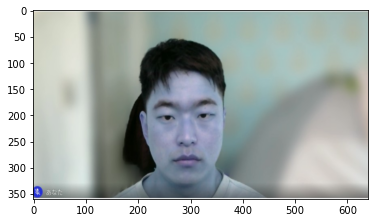

In [269]:
my_image_path = 'images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

でもbgr形式で持ってきたのでこれをrgb形式に変換させる

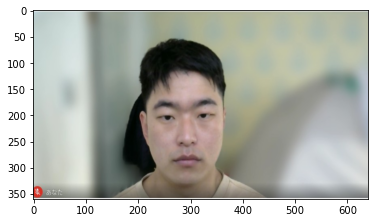

In [270]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

ああ見えても努力した様子

# 3.顔を見つけること

In [271]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 宣言


これを宣言する理由は顔面が何処にいるのかを見つけるためです。   
hog方式で顔面を探すそうです。

In [272]:
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)

rectangles[[(218, 167) (373, 322)]]


そして見つけた顔面の座標を獲得します。   
   
x1:218, y1:167   
x2:373, y2:322   
   
この座標は顔面がいる四角の領域を表します。

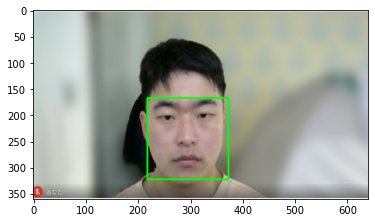

In [273]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) #これが長方形の線を塗る関数

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

獲得した座標をひとつひとつ分離して座標を得る   
   
cv2.rectangle(イメージ、(x1,y1), (x2,y2), 線の色) そして二つあるけどそれはなんだろう

# 4. 顔面の中の目鼻立ちを見つける

In [274]:
model_path = 'models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

目鼻立ちを見つけてくれるibug 300-wデータセットで学習したpretrained modelを変数に入れる。   
これを顔面の写真に使えば目鼻立ちを68個の座標を表してくれます。

In [275]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


実際にpretrained modelを使って68個の座標を得る

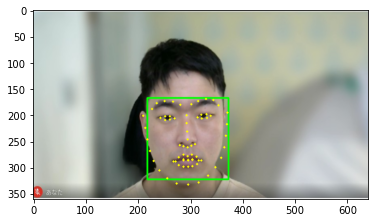

In [276]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

目鼻立ちを見つけってひとつひとつ線を塗った様子

# 5. 顔面い貼るステッカーを持って来る

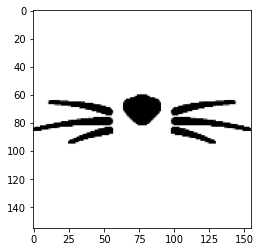

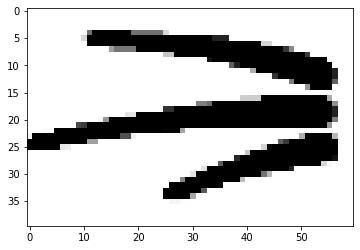

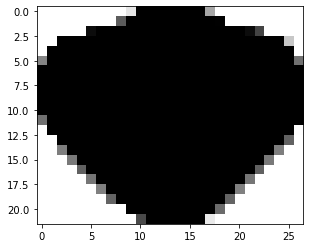

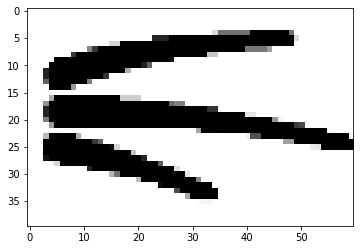

In [277]:
#顔面を見つけた四角の大きさ
w = r-l
h = b-t

my_image_path = 'images/cat-whiskers.png'
stiker = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
stiker = cv2.resize(stiker, (w, h))    # 640x360의 크기로 Resize
stiker = cv2.cvtColor(stiker, cv2.COLOR_BGR2RGB) #イメージが黒色なので必要ないかもしれないけど別の色だったら使うべき
stiker_show = stiker.copy()      #- 출력용 이미지 별도 보관
plt.imshow(stiker_show)
plt.show()


stiker_left = stiker.copy()[60:100, :60]
stiker_center = stiker.copy()[60:82, 64:91]
stiker_right = stiker.copy()[60:100, 95:]

plt.imshow(stiker_left)
plt.show()
plt.imshow(stiker_center)
plt.show()
plt.imshow(stiker_right)
plt.show()

鼻と頬にステッカー貼るため個々分離します。

# 6.顔面にステッカーを貼る

In [278]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


https://github.com/hahacandy/Aiffel_S/blob/main/EXPLORATION_DJ/3/pretrained%20model.png?raw=true   
これを参考し何処に貼るかを決めます。

### 鼻をつける

{'x1': 282, 'y1': 235, 'x2': 309, 'y2': 257}
(22, 27, 3)
(22, 27, 3)


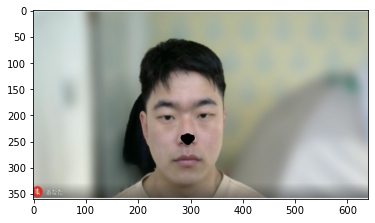

In [279]:
s_c_l = {'x1' : list_points[30][0]-stiker_center.shape[1]//2}
s_c_l['y1'] = list_points[30][1]-stiker_center.shape[0]//2
s_c_l['x2'] = list_points[30][0]+stiker_center.shape[1]//2 +stiker_center.shape[1]%2 # x1,y1が割り算して少数が出て捨てられたかもしれないので
s_c_l['y2'] = list_points[30][1]+stiker_center.shape[0]//2 +stiker_center.shape[0]%2

print(s_c_l)


stiker_center_area = img_rgb[s_c_l['y1']:s_c_l['y2'], s_c_l['x1']:s_c_l['x2']]

print(stiker_center_area.shape)
print(stiker_center.shape)

img_rgb[s_c_l['y1']:s_c_l['y2'], s_c_l['x1']:s_c_l['x2']] = np.where(stiker_center==0,stiker_center,stiker_center_area).astype(np.uint8)
plt.imshow(img_rgb)
plt.show()


### 髭を付ける

{'x1': 196, 'y1': 226, 'x2': 256, 'y2': 266}
(40, 60, 3)
(40, 60, 3)


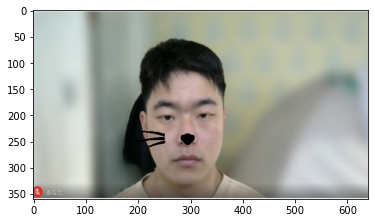

In [280]:
# ひだり
arr = []
left_cheek_x = (list_points[2][0]+list_points[30][0]) // 2
left_cheek_y = (list_points[36][1]+list_points[48][1]) // 2



left_cheek = (left_cheek_x, left_cheek_y) # x,y

# cv2.circle(img_rgb, left_cheek, 5, (0, 255, 255), -1) # yellow

s_l_l = {'x1' : left_cheek[0]-stiker_left.shape[1]}
s_l_l['y1'] = left_cheek[1]-stiker_left.shape[0]//2
s_l_l['x2'] = left_cheek[0] 
s_l_l['y2'] = left_cheek[1]+stiker_left.shape[0]//2 +stiker_left.shape[0]%2 # x1,y1が割り算して少数が出て捨てられたかもしれないので

print(s_l_l)



stiker_left_area = img_rgb[s_l_l['y1']:s_l_l['y2'], s_l_l['x1']:s_l_l['x2']]

print(stiker_left_area.shape)
print(stiker_left.shape)

img_rgb[s_l_l['y1']:s_l_l['y2'], s_l_l['x1']:s_l_l['x2']] = np.where(stiker_left==0,stiker_left,stiker_left_area).astype(np.uint8)
plt.imshow(img_rgb)
plt.show()


{'x1': 331, 'y1': 223, 'x2': 391, 'y2': 263}
(40, 60, 3)
(40, 60, 3)


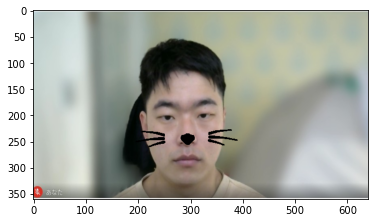

In [281]:
# みぎ
arr = []
right_cheek_x = (list_points[30][0]+list_points[14][0]) // 2
right_cheek_y = (list_points[45][1]+list_points[54][1]) // 2



right_cheek = (right_cheek_x, right_cheek_y) # x,y

# cv2.circle(img_rgb, right_cheek, 5, (0, 255, 255), -1) # yellow

s_r_l = {'x1' : right_cheek[0]}
s_r_l['y1'] = right_cheek[1]-stiker_right.shape[0]//2
s_r_l['x2'] = right_cheek[0] + stiker_right.shape[1]
s_r_l['y2'] = right_cheek[1]+stiker_right.shape[0]//2 +stiker_right.shape[0]%2 # x1,y1が割り算して少数が出て捨てられたかもしれないので

print(s_r_l)


stiker_right_area = img_rgb[s_r_l['y1']:s_r_l['y2'], s_r_l['x1']:s_r_l['x2']]

print(stiker_right_area.shape)
print(stiker_right.shape)

img_rgb[s_r_l['y1']:s_r_l['y2'], s_r_l['x1']:s_r_l['x2']] = np.where(stiker_right==0,stiker_right,stiker_right_area).astype(np.uint8)
plt.imshow(img_rgb)
plt.show()
